In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=18)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)

import math
import time 
# from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

# CFD Parameters

In [2]:
dt = 0.1
dx = 1.0
Re = 1 
ub = 1
nx = 128
ny = 128
nlevel = int(math.log(nx, 2)) + 1 

# Weights of CNNs layers

In [3]:
w1 = ([[[[0.25/dx**2], # Central differencing for diffusion and second-order time scheme
         [0.5/dx**2],
         [0.25/dx**2]],

        [[0.5/dx**2],
         [-3.0/dx**2],
         [0.5/dx**2]],

        [[0.25/dx**2],
         [0.5/dx**2],
         [0.25/dx**2]]]])

w2 = ([[[[1/(12*dx)],  # Central differencing for y-advection and second-order time scheme
         [0.0],
         [-1/(12*dx)]],

        [[1/(3*dx)],
         [0.0],
         [-1/(3*dx)]],

        [[1/(12*dx)],
         [0.0],
         [-1/(12*dx)]]]])

w3 = ([[[[-1/(12*dx)],  # Central differencing for y-advection and second-order time scheme
         [-1/(3*dx)],
         [-1/(12*dx)]],

        [[0.0],
         [0.0],
         [0.0]],

        [[1/(12*dx)],
         [1/(3*dx)],
         [1/(12*dx)]]]])

w4 = ([[[[-0.25/dx**2],        # A matrix for Jacobi
         [-0.5/dx**2],
         [-0.25/dx**2]],

        [[-0.5/dx**2],
         [3.0/dx**2],
         [-0.5/dx**2]],

        [[-0.25/dx**2],
         [-0.5/dx**2],
         [-0.25/dx**2]]]])

w4 = np.array(w4)
w5 = ([[[[-1/(12*dx)],        # Continuty in u -- div(u) / dt -- central differencing
         [0.0],
         [1/(12*dx)]],

        [[-1/(3*dx)],
         [0.0],
         [1/(3*dx)]],

        [[-1/(12*dx)],
         [0.0],
         [1/(12*dx)]]]])

w6 = ([[[[1/(12*dx)],        # Continuty in v -- div(v) / dt -- central differencing
         [1/(3*dx)],
         [1/(12*dx)]],

        [[0.0],
         [0.0],
         [0.0]],

        [[-1/(12*dx)],
         [-1/(3*dx)],
         [-1/(12*dx)]]]])

w7 = ([[[[-1/(12*dx)],        # Pressure in u central differencing delta p * dt
         [0.0],
         [1/(12*dx)]],

        [[-1/(3*dx)],
         [0.0],
         [1/(3*dx)]],

        [[-1/(12*dx)],
         [0.0],
         [1/(12*dx)]]]])

w8 = ([[[[1/(12*dx)],        # Pressure in v central differencing delta p * dt
         [1/(3*dx)],
         [1/(12*dx)]],

        [[0.0],
         [0.0],
         [0.0]],

        [[-1/(12*dx)],
         [-1/(3*dx)],
         [-1/(12*dx)]]]])
w9 = np.zeros([1,2,2,1])
w9[0][0][1][0] = 0.25
w9[0][1][0][0] = 0.25
w9[0][0][0][0] = 0.25
w9[0][1][1][0] = 0.25
w10 = np.ones([1,2,2,1])

In [4]:
wxu = np.zeros([1,3,3,1])
wxd = np.zeros([1,3,3,1])
wyu = np.zeros([1,3,3,1])
wyd = np.zeros([1,3,3,1])

In [5]:
wxu[0][1][1][0] = 1.0
wxu[0][1][0][0] = -1.0
wxd[0][1][1][0] = -1.0
wxd[0][1][2][0] = 1.0

wyu[0][1][1][0] = 1.0
wyu[0][0][1][0] = -1.0
wyd[0][1][1][0] = -1.0
wyd[0][2][1][0] = 1.0

In [6]:
w_c = np.zeros([1,3,3,1])
w_c[0][1][1][0] = 1
kernel_initializer_c = tf.keras.initializers.constant(w_c)

In [7]:
kernel_initializer_wxu = tf.keras.initializers.constant(wxu)
kernel_initializer_wxd = tf.keras.initializers.constant(wxd)
kernel_initializer_wyu = tf.keras.initializers.constant(wyu)
kernel_initializer_wyd = tf.keras.initializers.constant(wyd)

In [8]:
kernel_initializer_1 = tf.keras.initializers.constant(w1)
kernel_initializer_2 = tf.keras.initializers.constant(w2)
kernel_initializer_3 = tf.keras.initializers.constant(w3)
kernel_initializer_4 = tf.keras.initializers.constant(w4)
kernel_initializer_5 = tf.keras.initializers.constant(w5)
kernel_initializer_6 = tf.keras.initializers.constant(w6)
kernel_initializer_7 = tf.keras.initializers.constant(w7)
kernel_initializer_8 = tf.keras.initializers.constant(w8)
kernel_initializer_9 = tf.keras.initializers.constant(w9)
bias_initializer = tf.keras.initializers.constant(np.zeros((1,)))

# Libraries for solving momentum equation

In [9]:
CNN3D_central_2nd_dif = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer),
])

CNN3D_central_2nd_xadv = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_central_2nd_yadv = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_3,
                                bias_initializer=bias_initializer),
])

CNN3D_Su = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_5,
                                bias_initializer=bias_initializer),
])

CNN3D_Sv = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_6,
                                bias_initializer=bias_initializer),
])

CNN3D_pu = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_7,
                                bias_initializer=bias_initializer),
])

CNN3D_pv = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_8,
                                bias_initializer=bias_initializer),
])

In [10]:
CNN3D_wxu = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_wxu,
                                bias_initializer=bias_initializer),
])

CNN3D_wxd = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_wxd,
                                bias_initializer=bias_initializer),
])

CNN3D_wyu = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_wyu,
                                bias_initializer=bias_initializer),
])

CNN3D_wyd = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_wyd,
                                bias_initializer=bias_initializer),
])

# Libraries for multigrid algorithms

In [11]:
for i in range(nlevel):
    locals()['CNN3D_A_'+str(2**i)] = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(int(ny*0.5**(nlevel-1-i)), int(nx*0.5**(nlevel-1-i)), 1)),
         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',         
                                kernel_initializer=kernel_initializer_4,
                                bias_initializer=bias_initializer)
    ])

In [12]:
for i in range(nlevel-1):
    locals()['CNN3D_res_'+str(2**(i+1))] = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(int(ny*0.5**(nlevel-2-i)), int(nx*0.5**(nlevel-2-i)), 1)),
         tf.keras.layers.Conv2D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_9,
                                bias_initializer=bias_initializer),   
    ])    

In [13]:
for i in range(nlevel-1):
    locals()['CNN3D_prol_'+str(2**i)] = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(1*2**i, 1*2**i, 1)),
         tf.keras.layers.UpSampling2D(size=(2, 2)),
    ])

# Functions linking to the AI libraries

In [14]:
def boundary_condition_velocity(values_u,values_v,nx):
    'Define boundary conditions for velocity field'
    tempu = tf.Variable(values_u)
    tempv = tf.Variable(values_v)   
    tempu[0,:,0,0].assign(tf.Variable(values_u)[0,:,1,0]) 
    tempv[0,:,0,0].assign(tf.Variable(values_v)[0,:,1,0])    

    tempu[0,:,nx-1,0].assign(tf.Variable(values_u)[0,:,nx-2,0]) 
    tempv[0,:,nx-1,0].assign(tf.Variable(values_v)[0,:,nx-2,0])   
        
    tempu[0,0,:,0].assign(tf.Variable(values_u)[0,1,:,0])     
    tempv[0,0,:,0].assign(tf.Variable(values_v)[0,1,:,0])  
        
    tempu[0,nx-1,:,0].assign(tf.Variable(values_u)[0,nx-2,:,0])      
    tempv[0,nx-1,:,0].assign(tf.Variable(values_v)[0,nx-2,:,0])     
    return tempu,tempv

def boundary_condition_pressure(values_p,nx):
    'Define boundary conditions for pressure field'
    tempp = tf.Variable(values_p)   
#     tempp[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:]) 
    tempp[0,:,nx-1,0].assign(tf.Variable(values_p)[0,:,nx-2,0]) 
    tempp[0,:,0,0].assign(tf.Variable(values_p)[0,:,1,0])
    
    tempp[0,nx-1,:,0].assign(tf.Variable(values_p)[0,nx-2,:,0])     
#     tempp[0,0,:,0].assign(tf.Variable(values_p)[0,1,:,0])
    tempp[0,0,:,0].assign(tf.Variable(tf.ones((1,nx)))[0,:]*10*1000*-1) 
    return tempp

def boundary_condition_indicator(alpha,nx):   
    'Define boundary conditions for scalar field'
    tempa = tf.Variable(alpha)   
    tempa[0,:,nx-1,0].assign(tf.Variable(alpha)[0,:,nx-2,0]) 
    tempa[0,:,0,0].assign(tf.Variable(alpha)[0,:,1,0])
    
    tempa[0,0,:,0].assign(tf.Variable(alpha)[0,1,:,0])     
    tempa[0,nx-1,:,0].assign(tf.Variable(alpha)[0,nx-2,:,0]) 
    return tempa

def boundary_condition_source(b,nx):  
    'Define inflow boundary conditions for source terms to'
    'avoid incorrect paddings caused by CNNs'
    tempb = tf.Variable(b)   
    tempb[0,0,:,0].assign(tf.Variable(b)[0,1,:,0]*0)
    tempb[0,nx-1,:,0].assign(tf.Variable(b)[0,nx-2,:,0]*0)
    tempb[0,:,nx-1,0].assign(tf.Variable(b)[0,:,nx-2,0]*0)
    tempb[0,:,0,0].assign(tf.Variable(b)[0,:,1,0]*0)
    return tempb

def bluff_body(values_u,values_v,alpha,sigma):
    'Immersed Boundary for buildings'
    temp1 = values_u / (1+dt*sigma) 
    temp2 = values_v / (1+dt*sigma)
    # temp3 = values_w / (1+dt*sigma) 
    temp4 = alpha / (1+dt*sigma)
    return temp1,temp2,temp4

def save_data(alpha,n_out,itime):
    'Save field data'
    if itime % n_out == 0:  
        np.save("data_SK_tracer/alpha"+str(itime), arr=alpha[0,:,:,:,0])
        np.save("data_SK_tracer/v"+str(itime), arr=values_v[0,:,:,:,0])
        np.save("data_SK_tracer/w"+str(itime), arr=values_w[0,:,:,:,0])
        np.save("data_SK_tracer/p"+str(itime), arr=values_p[0,:,:,:,0])

In [15]:
def PG_turb_vector(values_u, values_v, eplsion_k):    
    '''Turbulence modelling using Petrov-Galerkin dissipation       
    Input
    ---------------------------------------------------------------------
    values_u: u-component velocity 
    values_v: v-component velocity 
    values_w: w-component velocity 
    eplsion_k: Need to sufficiently large
    
    Output
    ---------------------------------------------------------------------
    k_x: Final diffusion matrix in x direction 
    k_y: Final diffusion matrix in y direction 
    k_z: Final diffusion matrix in z direction 
    '''

    k_u = 0.4 * 0.25 * abs(1/3*
                               (abs(values_u) + abs(values_v)) * 
                               CNN3D_central_2nd_dif(values_u)) / (eplsion_k + 
                               (abs(CNN3D_central_2nd_xadv(values_u)) + 
                               abs(CNN3D_central_2nd_yadv(values_u)))/3)
    
    k_v = 0.4 * 0.25 * abs(1/3*
                               (abs(values_u) + abs(values_v)) * 
                               CNN3D_central_2nd_dif(values_v)) / (eplsion_k + 
                               (abs(CNN3D_central_2nd_xadv(values_v)) + 
                               abs(CNN3D_central_2nd_yadv(values_v)))/3)
  
    k_u = tf.math.minimum(k_u, tf.ones(input_shape)*0.25/dt) 
    k_v = tf.math.minimum(k_v, tf.ones(input_shape)*0.25/dt)   
    
    k_x = 3*0.5*(k_u*CNN3D_central_2nd_dif(values_u) +
                CNN3D_central_2nd_dif(values_u*k_u) -
                values_u*CNN3D_central_2nd_dif(k_u))

    k_y = 3*0.5*(k_v*CNN3D_central_2nd_dif(values_v) + 
                CNN3D_central_2nd_dif(values_v*k_v) -
                values_v*CNN3D_central_2nd_dif(k_v))

    return k_x, k_y

In [16]:
def PG_turb_scalar(alpha, values_u, values_v, eplsion_k):    
    '''Turbulence modelling using Petrov-Galerkin dissipation       
    Input
    ---------------------------------------------------------------------
    values_u: u-component velocity 
    values_v: v-component velocity 
    values_w: w-component velocity 
    eplsion_k: Need to sufficiently large
    
    Output
    ---------------------------------------------------------------------
    k_alpha: Final diffusion matrix in x direction 
    '''
    alpha_x = CNN3D_central_2nd_xadv(alpha)  
    alpha_y = CNN3D_central_2nd_yadv(alpha)  

    Sx = CNN3D_wxu(alpha)*CNN3D_wxd(alpha)
    Sy = CNN3D_wyu(alpha)*CNN3D_wyd(alpha)

    Sx = tf.where((tf.less(Sx,tf.zeros(input_shape))),-tf.ones(input_shape),Sx)  
    Sy = tf.where((tf.less(Sy,tf.zeros(input_shape))),-tf.ones(input_shape),Sy)   

    wx_u = -tf.math.maximum(tf.ones(input_shape)*-1, tf.math.minimum(tf.zeros(input_shape),Sx))
    wx_d = tf.math.maximum(tf.ones(input_shape)*-1, tf.math.minimum(tf.zeros(input_shape),Sx))
    wy_u = -tf.math.maximum(tf.ones(input_shape)*-1, tf.math.minimum(tf.zeros(input_shape),Sy))
    wy_d = tf.math.maximum(tf.ones(input_shape)*-1, tf.math.minimum(tf.zeros(input_shape),Sy))    

    scaling_x = alpha_x*(values_u*alpha_x+values_v*alpha_y)/\
    (eplsion_k+alpha_x**2+alpha_y**2)

    scaling_y = alpha_y*(values_u*alpha_x+values_v*alpha_y)/\
    (eplsion_k+alpha_x**2+alpha_y**2)
 

    k_u = 300*abs(1/2*(abs(values_u)+abs(values_v))*CNN3D_central_2nd_dif(alpha))/\
    (eplsion_k+(abs(alpha_x)+abs(alpha_y))/2)

    k_d = -0.25*(values_u**2+values_v**2)/\
    (eplsion_k+scaling_x**2+scaling_y**2)**0.5

    k_x = wx_d*k_d+wx_u*k_u
    k_y = wy_d*k_d+wy_u*k_u

    k_xf = tf.math.minimum(k_x,tf.ones(input_shape)*0.25/dt,(values_u**2+values_v**2)**0.5)
    k_yf = tf.math.minimum(k_y,tf.ones(input_shape)*0.25/dt,(values_u**2+values_v**2)**0.5)

    k_alpha = 0.5*(k_xf*CNN3D_central_2nd_dif(alpha)+
                   CNN3D_central_2nd_dif(alpha*k_xf)-
                   alpha*CNN3D_central_2nd_dif(k_xf))+\
              0.5*(k_yf*CNN3D_central_2nd_dif(alpha)+
                   CNN3D_central_2nd_dif(alpha*k_yf)-
                   alpha*CNN3D_central_2nd_dif(k_yf))                 
    return k_alpha,alpha_x,alpha_y,scaling_x,scaling_y,k_u,k_d,Sx,Sy,k_x,k_y,k_xf,k_yf

# Initialise

In [24]:
#################### Create field #####£###############
input_shape = (1,nx,ny,1)
values_u = tf.ones(input_shape)
values_v = tf.zeros(input_shape)
# values_w = tf.zeros(input_shape)
# values_p = tf.zeros(input_shape)
#######################################################
################# Numerical parameters ################
multi_itr = 100               # Iterations of multi-grid 
j_itr = 1                   # Iterations of Jacobi 
ntime = 100                # Time steps
n_out = 200                 # Results output
nrestart = 0                # Last time step for restart
ctime_old = 0               # Last ctime for restart
mgsolver = False             # Multigrid solver
LSCALAR = True              # Scalar transport 
LMTI = True                 # Non density for multiphase flows
LIBM = False                # Immersed boundary method 
nsafe = 0.5                 # Continuty equation residuals
ctime = 0                   # Initialise ctime   
save_fig = False             # Save results
Restart = False             # Restart
eplsion_k = 1e-03
################# Physical parameters #################
rho_l = 1000               # Density of liquid phase 
rho_g = 1000                # Density of gas phase 
g_x = 0;g_y = 0;g_z = -10   # Gravity acceleration (m/s2) 
#######################################################
print('============== Numerical parameters ===============')
print('Mesh resolution:', values_v.shape)
print('Time step:', ntime)
print('Initial time:', ctime)
#######################################################
################# Only for restart ####################
if Restart == True:
    temp1 = np.load('data_SK/u2500.npy').astype('float32')
    temp2 = np.load('data_SK/v2500.npy').astype('float32')
    temp3 = np.load('data_SK/w2500.npy').astype('float32')
    temp4 = np.load('data_SK/p2500.npy').astype('float32')
    values_u = tf.Variable(values_u)[0,:,:,:,0].assign(tf.convert_to_tensor(temp1))
    values_v = tf.Variable(values_v)[0,:,:,:,0].assign(tf.convert_to_tensor(temp2))
    values_w = tf.Variable(values_w)[0,:,:,:,0].assign(tf.convert_to_tensor(temp3))
    values_p = tf.Variable(values_p)[0,:,:,:,0].assign(tf.convert_to_tensor(temp4))
    nrestart = 2500
    ctime_old = nrestart*dt
    print('Restart solver!')
#######################################################    
################# Only for scalar #####################
if LSCALAR == True:
    alpha = np.zeros(input_shape).astype('float32')
    alpha[0,44:84,44:84,0] = 1.0
#     alpha[0,64:128,:,:,0] = 1.0
    alpha = tf.convert_to_tensor(alpha)
    print('Switch on scalar filed solver!')
#######################################################
################# Only for scalar #####################
if LMTI == True:
    rho = tf.zeros(input_shape)
    rho = alpha*rho_l + (1-alpha)*rho_g
    print('Solving multiphase flows!')
else:
    rho = tf.ones(input_shape)
    print('Solving single-phase flows!')
################# Only for IBM ########################
if LIBM == True:
    mesh = np.load('mesh_512_sk.npy')
    sigma = np.zeros(input_shape).astype('float32')
    for i in range(1,nx-1):
        for j in range(1,ny-1):
            for k in range(1,nz-1):
                if mesh[0][i+64][j+64][k][0] == 0:
                    sigma[0][k][j][i][0] = 100000  
    sigma = tf.convert_to_tensor(sigma)
    print('Switch on IBM solver!')
    print('===================================================')
    plt.imshow(sigma[0,1,:,:,0], cmap='jet')
    plt.colorbar()
    plt.title('South Kensington area')
#######################################################

============== Numerical parameters ===============
Mesh resolution: (1, 128, 128, 1)
Time step: 100
Initial time: 0
Switch on scalar filed solver!
Solving multiphase flows!


# Initial condition

Text(0.5, 1.0, 'Initial field')

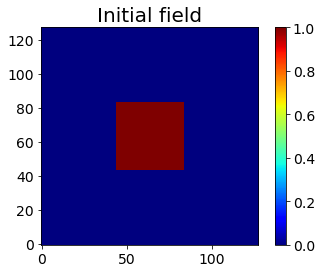

In [18]:
plt.imshow(alpha[0,:,:,0], cmap='jet')
plt.colorbar()
plt.gca().invert_yaxis()
plt.title('Initial field', fontsize=20)

# Advection-Diffusion case

In [19]:
for itime in range(1,ntime+1): 
    a_t = CNN3D_central_2nd_dif(alpha)*dt - \
    CNN3D_central_2nd_xadv(values_u*alpha)*dt - \
    CNN3D_central_2nd_yadv(values_v*alpha)*dt 
    alpha = alpha + a_t*0.5

    a_t = CNN3D_central_2nd_dif(alpha)*dt - \
    CNN3D_central_2nd_xadv(values_u*alpha)*dt - \
    CNN3D_central_2nd_yadv(values_v*alpha)*dt 
    alpha = alpha + a_t

Text(0.5, 1.0, 'Advection-diffusion')

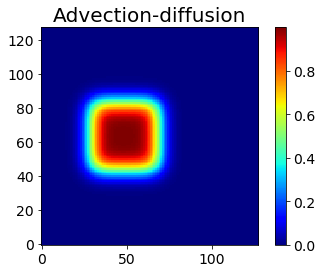

In [20]:
plt.imshow(alpha[0,:,:,0], cmap='jet')
plt.colorbar()
plt.gca().invert_yaxis()
plt.title('Advection-diffusion', fontsize=20)

# Pure advection case 

In [22]:
for itime in range(1,ntime+1): 
    a_t = 0*CNN3D_central_2nd_dif(alpha)*dt - \
    CNN3D_central_2nd_xadv(values_u*alpha)*dt - \
    CNN3D_central_2nd_yadv(values_v*alpha)*dt 
    alpha = alpha + a_t*0.5

    a_t = 0*CNN3D_central_2nd_dif(alpha)*dt - \
    CNN3D_central_2nd_xadv(values_u*alpha)*dt - \
    CNN3D_central_2nd_yadv(values_v*alpha)*dt 
    alpha = alpha + a_t

Text(0.5, 1.0, 'Pure advection')

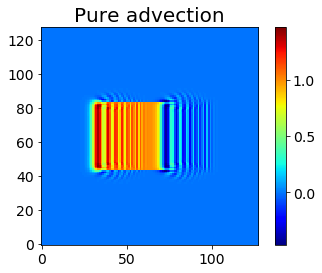

In [23]:
plt.imshow(alpha[0,:,:,0], cmap='jet')
plt.colorbar()
plt.gca().invert_yaxis()
plt.title('Pure advection', fontsize=20)

# Pure advection case with compressive interface tracking

In [25]:
for itime in range(1,ntime+1): 
    [k_alpha,alpha_x,alpha_y,scaling_x,scaling_y,k_u,k_d,Sx,Sy,k_x,k_y,k_xf,k_yf] = PG_turb_scalar(alpha, values_u, values_v, eplsion_k)
    a_t = k_alpha*dt - \
    CNN3D_central_2nd_xadv(values_u*alpha)*dt - \
    CNN3D_central_2nd_yadv(values_v*alpha)*dt 
    alpha = alpha + a_t*0.5

    [k_alpha,alpha_x,alpha_y,scaling_x,scaling_y,k_u,k_d,Sx,Sy,k_x,k_y,k_xf,k_yf] = PG_turb_scalar(alpha, values_u, values_v, eplsion_k)
    a_t = k_alpha*dt - \
    CNN3D_central_2nd_xadv(values_u*alpha)*dt - \
    CNN3D_central_2nd_yadv(values_v*alpha)*dt 
    alpha = alpha + a_t

Text(0.5, 1.0, 'Compressive-advection')

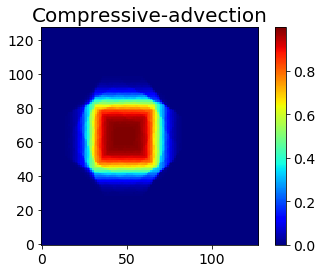

In [26]:
plt.imshow(alpha[0,:,:,0], cmap='jet')
plt.colorbar()
plt.gca().invert_yaxis()
plt.title('Compressive-advection', fontsize=20)